# Imports

In [1]:
# for data analysis
import numpy as np
import pandas as pd

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for outlier capping
from scipy.stats.mstats import winsorize
import scipy.stats as stats  # Import statistical functions - used for Chi-Square

# for text pattern matching
import re

In [2]:
cost_of_living = pd.read_csv("C:/Users/barbe/OneDrive/DS Projects/Cost of Living Prediction/cost_of_living_us.csv")

# Clean Dataset

Start by cleaning the dataset

In [3]:
# Drop missing values
cost_of_living = cost_of_living.dropna(subset=['median_family_income'])

# Convert all object columns to category
for col in cost_of_living.select_dtypes(include=['object']).columns:
    cost_of_living[col] = cost_of_living[col].astype('category')

# select numerical columns
num_cols = cost_of_living.select_dtypes(include=['number']).columns

In [4]:
#define function to identify outliers via IQR
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

#create dataframe to store outliers
outliers_df = pd.DataFrame()

#apply function to numerical variables
#iterate over variables
for var in num_cols:
    outliers = identify_outliers(cost_of_living, var)
    #concatenate outliers to outlier dataframe
    outliers_df = pd.concat([outliers_df, outliers])

#drop duplicate rows since some rows may be outliers in multiple columns
outliers_df = outliers_df.drop_duplicates()

In [5]:
# Define a function to cap outliers
def cap_outliers(data, column, lower_pct=0.05, upper_pct=0.95):
    data[column] = winsorize(data[column], limits=(lower_pct, 1-upper_pct))
    return data

# Apply the function to all numerical columns
for var in num_cols:
    col_clean = cap_outliers(cost_of_living, var)

In [6]:
# Function to extract parent and child counts
def extract_family_counts(family_str):
    if isinstance(family_str, str):  # Ensure the input is a string
        match = re.match(r'(\d+)p(\d+)c', family_str)  # Regex to extract numbers before 'p' and 'c'
        if match:
            num_parents = int(match.group(1))  # Extract parent count
            num_children = int(match.group(2))  # Extract child count
        else:
            num_parents, num_children = 0, 0  # Default for unexpected formats
    else:
        num_parents, num_children = 0, 0  # Handle non-string cases safely

    return num_parents, num_children

# Ensure 'family_member_count' is a string before applying the function
col_clean['family_member_count'] = col_clean['family_member_count'].astype(str)

# Apply function to create new columns
col_clean[['num_parents', 'num_children']] = col_clean['family_member_count'].apply(lambda x: pd.Series(extract_family_counts(x)))

# Create total family size column
col_clean['family_total'] = col_clean['num_parents'] + col_clean['num_children']

# Drop case_id and family_member_count columns
col_clean = col_clean.drop(columns=['case_id', 'family_member_count'])

In [7]:
def initial_look(df, n=5):
    """Provides a quick overview of the dataset, including structure and metadata.
    
    Parameters:
    df (DataFrame): The dataset to inspect.
    n (int, optional): Number of rows to display from the top (default is 5).
    
    Outputs:
    - Displays first few rows.
    - Prints dataset shape (row, column count).
    - Prints dataset metadata (column types, missing values, memory usage).
    """
    print("\nFirst few rows:")
    print(df.head(n))  # Show first 'n' rows to get an overview

    print("\nDataset shape (rows, columns):", df.shape)  # Display number of rows & columns

    print("\nDataset info:")
    df.info()  # Shows column names, types, non-null values, and memory usage

In [8]:
initial_look(col_clean)


First few rows:
  state  isMetro            areaname          county  housing_cost  \
0    AL     True  Montgomery, AL MSA  Autauga County    8505.72876   
1    AL     True  Montgomery, AL MSA  Autauga County   12067.50240   
2    AL     True  Montgomery, AL MSA  Autauga County   12067.50240   
3    AL     True  Montgomery, AL MSA  Autauga County   15257.15040   
4    AL     True  Montgomery, AL MSA  Autauga County   15257.15040   

     food_cost  transportation_cost  healthcare_cost  other_necessities_cost  \
0   3454.91712          10876.68600       5737.47984              4333.81344   
1   5091.70788          11588.19288       8659.55640              6217.45896   
2   7460.20308          12361.77720      11581.63260              7075.65816   
3   9952.23924          13452.18600      14503.70760              9134.35620   
4  12182.21400          13744.59840      17425.78560              9942.36396   

   childcare_cost        taxes   total_cost  median_family_income  \
0          0

# Exploratory Data Analysis

With the data cleaned, let's begin some EDA.
- Descriptive statistics and distributions
- Correlation Analysis
- Categorical & Boolean Analysis

## Descriptive statistics and distributions

In [9]:
# Summary statistics for numerical features
col_clean.describe()

,housing_cost,food_cost,transportation_cost,healthcare_cost,other_necessities_cost,childcare_cost,taxes,total_cost,median_family_income,num_parents,num_children,family_total
count,31420.000000,31420.000000,31420.000000,31420.000000,31420.000000,31420.000000,31420.000000,31420.000000,31420.000000,31420.000000,31420.000000,31420.000000
mean,10847.685407,8234.022056,13608.588949,13278.099540,6920.566416,9674.830651,7475.150471,70273.973868,67783.892469,1.500000,2.000000,3.500000
std,3217.831762,3114.649082,1473.818296,4823.246718,2068.669212,6296.855351,2494.108926,19964.024286,14221.589582,0.500008,1.414236,1.500024
min,6456.000000,3154.038240,10876.686000,5221.394520,3558.324840,0.000000,4174.750080,35624.622000,45789.253906,1.000000,0.000000,1.000000
25%,8580.000000,5801.424360,12535.204200,9667.440000,5286.337290,5341.208880,5597.540100,53773.911300,57223.988281,1.000000,1.000000,2.000000
50%,10416.000000,8129.156280,13698.315000,13082.514000,6733.056120,10166.340120,6897.747780,70974.249000,65955.605469,1.500000,2.000000,3.500000
75%,12444.000000,10703.624280,14765.867400,16657.816800,8412.597480,14272.137600,8789.137950,85368.045300,76136.070312,2.000000,3.000000,5.000000
max,18810.618000,13842.232800,16022.937600,22315.900800,11097.565440,20340.411600,13464.391200,106261.324800,99759.234375,2.000000,4.000000,6.000000


**Analyze Table**
Note:
- The median total cost of living is $\$70,974$, with a wide range from $\$35,624$ to $\$106,261$, indicating significant regional differences
- Median family income is $\$65,955$, but varies from $\$45,789$ to $\$99,759$, suggesting income disparities that may affect affordability
- Housing, food, and transportation costs make up a large portion of total expenses, reinforcing their importance in financial planning
- Cost of living varies significantly across locations, requiring regional analysis
- Income disparities suggest affordability challenges, especially for lower-income families.
- The standard deviations for housing ($\$3,217$) and for food ($\$3,114$) have moderate variation, indicating costs fluctuate but stay within a reasonable range.
- Healthcare and childcare costs have higher standard deviations, suggesting major regional differences in expenses.
- Taxes have a std of $\$2,494$. This is a significant spread likely due to state-level tax policies
- Median number of parents is 1.5, showcasing that many families are single-parent households. This likely causes unique financial challenges.
- Median number of children is 2 while median family total is 3.5. This confirms that most families consists of one or two parents with children.
- Larger families tend to have higher total costs, reinforcing the impact of family size on affordability
- Single-parent households are common, which may affect financial stability
- Family size directly impacts affordability, making it a key factor in cost analysis.

**Modeling Considerations**
There are some feature scaling considerations:
- There is a wide range in numerical values and standard deviations vary significantly.
- Normalization or standardization may be needed.

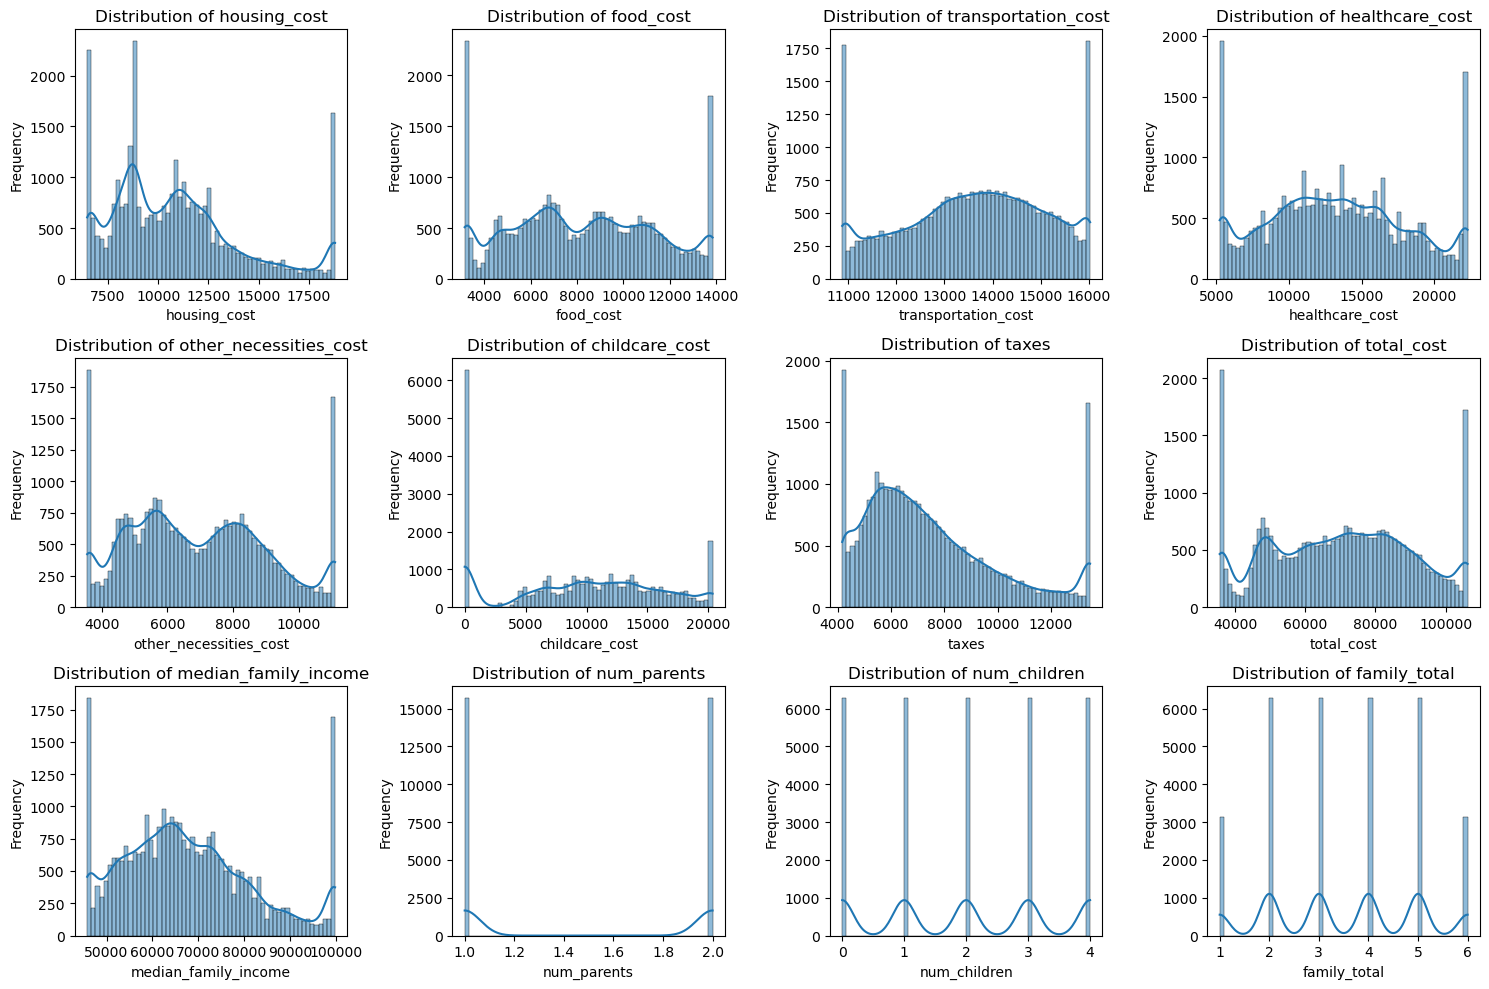

In [10]:
# Select numerical columns
num_cols = col_clean.select_dtypes(include=['number']).columns

# Define subplot grid dynamically based on the number of features
rows = 3  # Adjust if necessary
cols = min(len(num_cols), 4)  # Limit to 4 columns for better layout
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))  # Create subplots
axes = axes.flatten()  # Flatten the array to make iteration easier

# Iterate over numerical variables and plot histograms with KDE
for i, var in enumerate(num_cols):
    sns.histplot(col_clean[var], bins=60, kde=True, ax=axes[i])  # Add KDE for density visualization
    axes[i].set_title(f'Distribution of {var}')  # Set plot title
    axes[i].set_xlabel(var)  # Label x-axis
    axes[i].set_ylabel('Frequency')  # Label y-axis

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

**Analyze Plots**
- Housing and childcare costs show variation, with some families experiencing much higher expenses than others.
- Childcare costs have a noticeable peak at zero, indicating that some families do not pay for childcare, possibly due to subsidies or family-based care.
- Food, transportation, and healthcare costs appear more evenly spread, suggesting that these expenses are relatively stable across different households
- Taxes exhibit a wide range, indicating that tax burden significantly varies by location.
- Total cost displays substantial variation, reflecting different affordability challenges across regions.
- Median family income varies widely, reinforcing economic differences across the dataset.
- Income distribution does not directly match total cost distribution, meaning affordability trends may require further analysis.
- Higher-income households are present, but income disparity suggests that financial strain could differ among families.
- Number of parents is mostly 1 or 2, showing the prevalence of single-parent and two-parent households.
- Number of children ranges from 0 to 4, confirming that while larger families exist, smaller families are more common.
- Family total follows a similar clustering pattern, reinforcing expected family sizes



**Modeling Considerations**
- Scaling adjustments may be necessary, especially for highly variable cost categories like housing and childcare.
- Transformations could help with right-skewed features to stabilize modeling outcomes.
- Affordability cannot be modeled as a simple linear relationship between income and total cost, and more complex methods may be required to accurately capture financial strain.
- Categorical encoding may be useful for family structure variables, as distinct clusters exist for household composition.
- Interaction terms (e.g., num_children * childcare_cost) could improve model performance, particularly for cost-related predictions.

## Correlation Analysis

In [11]:
# Select only numeric features
numerical_vars = col_clean.select_dtypes(include=['number'])

# Compute Pearson correlation
pearson_corr = numerical_vars.corr(method='pearson')

# Compute Spearman correlation
spearman_corr = numerical_vars.corr(method='spearman')

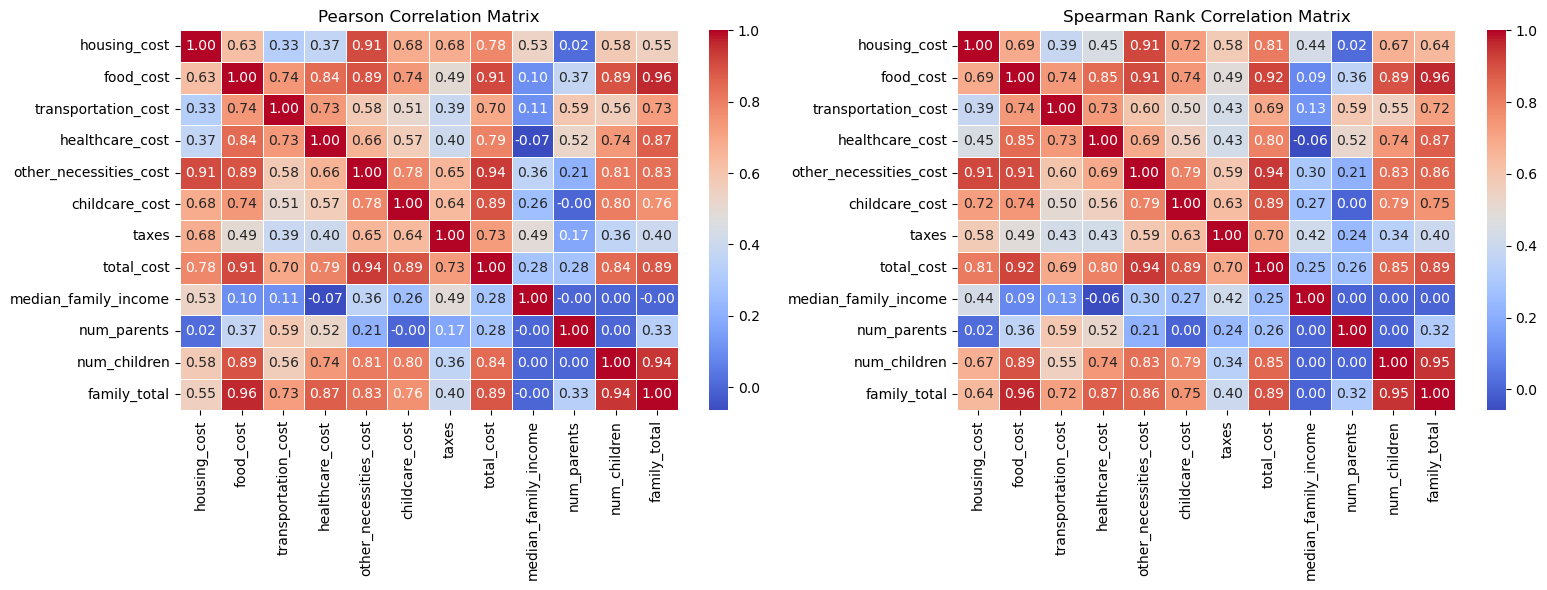

In [13]:
# Create subplot setup (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

# Pearson Correlation Heatmap (Left)
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axes[0])
axes[0].set_title("Pearson Correlation Matrix")

# Spearman Correlation Heatmap (Right)
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axes[1])
axes[1].set_title("Spearman Rank Correlation Matrix")

# Adjust layout for better readability
plt.tight_layout()
plt.show()

### Correlation Analysis Part 2
- Putting together insights

**Pearson correlation** measures linear relationships between numerical features, identifying key cost drivers and potential redundancy. **Spearman correlation** measures monotonic relationships, revealing patterns that may not be strictly linear but still follow an ordered ranking. By considering both approaches, a more complete understanding of household expense relationships emerges.
- Housing cost and other necessities cost have a correlation of 0.91 in both Pearson and Spearman analyses. Families with higher housing expenses tend to spend more on utilities, household supplies, and other essential needs, suggesting location-based factors influence affordability. The correlation between housing cost and total cost is slightly stronger in Spearman (0.81) than Pearson, reinforcing its role as a ranked predictor of overall financial burden.
- Food cost has strong correlations with multiple expense categories. Healthcare cost has a Pearson correlation of 0.84 and Spearman correlation of 0.85, indicating that households spending more on food often rank higher in healthcare costs, possibly due to dietary-related health expenses. Other necessities cost has a Pearson correlation of 0.89 and Spearman correlation of 0.91, confirming food spending as a key driver of household necessities. Total cost has a Pearson correlation of 0.91 and Spearman correlation of 0.92, reinforcing food as a major component of overall financial burden. Family-related variables, such as num_children and family_total, have correlations of 0.89 and 0.96, respectively, in both Pearson and Spearman. Larger families require more food, explaining the strong relationship between these features.
- Healthcare cost and family total have a correlation of 0.87 in both Pearson and Spearman analyses. Larger households tend to have higher medical expenses, reinforcing the impact of family size on healthcare spending. Healthcare cost also has a stronger rank-based correlation with total cost in Spearman (0.80), suggesting that households consistently ranked higher in healthcare spending also rank higher in total expenses.
- Other necessities cost and total cost have a correlation of 0.94 in both Pearson and Spearman analyses. This confirms that necessities spending is a major financial burden, influencing overall household expenses. The correlation between other necessities cost and family size is slightly stronger in Spearman (0.86 vs. 0.83 Pearson), indicating that larger households generally rank higher in necessities spending.
- Childcare cost has strong correlations with total cost, num_children, and family_total. The correlation with total cost is 0.89 in both Pearson and Spearman, confirming childcare as one of the highest financial burdens for families. Num_children has a correlation of 0.80 in Pearson and 0.79 in Spearman, reinforcing that childcare costs generally scale with family size. Family_total has a Spearman correlation of 0.75, slightly lower than Pearson (0.83), suggesting that ranked household size does not perfectly determine childcare expenses.
- Total cost and family size variables are closely related across both correlation measures. Num_children has a Pearson correlation of 0.84 and Spearman correlation of 0.85, while family_total has a Pearson correlation of 0.89 and Spearman correlation of 0.89. These values confirm that larger families consistently have higher total household expenses, making family size a key predictor of financial strain
- Taxes show weak correlations across all expense categories in both Pearson and Spearman analyses. Tax burdens do not scale proportionally with spending and may be determined by fixed tax rates and location-specific policies rather than household financial behavior.
- Median family income has low correlations across all expense categories, reaffirming that income alone does not determine household expenses. Financial behaviors, savings strategies, and local cost-of-living differences likely play a more significant role. This suggests affordability modeling may require transformation techniques, such as log scaling, to better capture income trends.

**Modeling Considerations**
- Num_children and family_total have a correlation between 0.94 and 0.95 across both Pearson and Spearman. Since family_total already accounts for num_children, one of these should be removed to prevent duplication while maintaining predictive accuracy.
- Total cost aggregates individual expense categories, meaning models that predict cost breakdowns should focus on individual cost components rather than total cost alone.
- Affordability cannot be modeled as a simple income-expense relationship. Since income does not strongly correlate with expenses, models must account for external factors such as subsidies, financial behaviors, and regional cost-of-living differences to provide accurate predictions.
- Categorical encoding for family structure may improve predictions. Household composition variables such as num_parents and num_children influence spending patterns, meaning encoding these as categorical rather than continuous values may enhance model accuracy.
- Transformation techniques may be useful for certain features. Log scaling may help stabilize right-skewed variables, preventing extreme values from distorting predictions. Affordability models may also benefit from nonlinear approaches such as decision trees or clustering methods rather than purely linear methods.

### Correlation Analysis part 1
- Looking at every significant correlation.

**Pearson Correlation** measures linear relationships between numeric features, helping to identify key cost drivers and potential redundancy.
- Housing Cost and Other Necessities Cost (0.91): Families spending more on housing tend to have higher spending on utilities, household supplies, and other essential needs.
- Food Cost correlations: Healthcare Cost (0.84), Other Necessities Cost (0.89), Total Cost (0.91), Num Children (0.89), Family Total (0.96). Food is a major household expense, explaining its strong relationship with total cost. Larger families require more food, which accounts for the high correlation with family_total (0.96) and num_children (0.89). The link to healthcare (0.84) suggests diet plays a role in medical expenses, reinforcing food costs as a predictor of both financial and health trends.
- Transportation Cost (~0.7–0.74 correlations). Moderately correlated with multiple expenses, indicating spending on commuting and access to services may be influenced by regional or lifestyle factors.
- Healthcare Cost and Family Total (0.87). Larger families tend to incur higher medical expenses, confirming a strong relationship between healthcare costs and household size.
- Other Necessities Cost correlations: Total Cost (0.94), Num Children (0.81), Family Total (0.83). Strong correlation with total cost (0.94) confirms its role as a major financial burden. Its relationship with family size suggests that larger households require more basic necessities.
- Childcare Cost correlations: Total Cost (0.89), Num Children (0.80). Childcare expenses scale with family size, explaining their correlation with total cost and number of children.
- Taxes (No notable correlations). Tax values do not strongly correlate with household expenses, reinforcing their independent function rather than scaling proportionally with total spending.
- Total Cost correlations: Num Children (0.84), Family Total (0.89). A strong relationship confirms family size is a major driver of overall expenses, which is expected. Since total_cost already aggregates all spending, removing either num_children or family_total may simplify the dataset without losing valuable insights.
- Median Family Income (Low correlations across all expense categories). Weak correlation suggests that income alone does not determine household expenses. Financial behaviors, savings strategies, and cost-of-living differences likely play a larger role in spending.
- Num Parents (Low correlations across all expense categories). Minimal correlation suggests that the number of parents in a household does not significantly impact major expenses. Unless additional non-linear relationships emerge, this feature may not be necessary for inclusion.
- Num Children and Family Total (0.94). A near-perfect correlation confirms that keeping both is redundant. Since family_total already includes num_children, one should be removed to prevent duplication while maintaining predictive accuracy.

**Spearman Correlation** measures monotonic relationships, detecting trends that may not be linear but still follow an ordered pattern.
- Housing Cost and Other Necessities Cost (0.91), Total Cost (0.81). Households with higher housing expenses tend to rank higher in spending on utilities and other essentials, confirming a consistent trend. The correlation with total cost (0.81) reinforces that housing remains a key driver of overall expenses, though its ranking impact is slightly lower than necessities.
- Food Cost correlations: Healthcare Cost (0.85), Other Necessities Cost (0.91), Total Cost (0.92), Num Children (0.89), Family Total (0.96). Spearman confirms food costs scale predictably with total household expenses, reinforcing its major role in financial planning. A strong correlation with healthcare costs (0.85) suggests that households ranking higher in food spending also rank higher in medical expenses, potentially due to dietary impact. The relationship with num_children (0.89) and family_total (0.96) aligns with expectations—larger families spend more on food.
- Transportation Cost (~0.7 correlations across multiple categories).
- Healthcare Cost correlations: Total Cost (0.80), Family Total (0.87). Spearman reaffirms that higher healthcare spending is ranked alongside larger family sizes, confirming that households with more family members tend to incur greater medical expenses.
- Other Necessities Cost correlations: Total Cost (0.94), Family Total (0.86). Strong correlation with total cost (0.94) suggests that necessities play a significant role in overall household expenses. The relationship with family_total (0.86) indicates larger households rank higher in necessities spending, making family structure a clear influence on this category.
- Childcare Cost correlations: Total Cost (0.89), Num Children (0.79), Family Total (0.75). A high ranking trend with total cost (0.89) confirms childcare remains one of the highest financial burdens for families. The moderate link to family size variables suggests that childcare spending increases with household size, though not perfectly proportionally.
- Taxes (Low correlations across all categories)
- Total Cost correlations: Num Children (0.85), Family Total (0.89). Households with more children or larger family sizes rank higher in total expenses, confirming a direct relationship between family structure and financial burden.
- Median Family Income (Low correlations across all categories). Weak correlations reaffirm income does not directly determine household expenses in a ranked manner. This suggests spending behaviors and financial choices vary across income levels, making income transformation (e.g., log scaling) potentially beneficial for capturing affordability trends.
- Num Parents (Low correlations across all categories). The lack of strong ranked relationships suggests that the number of parents does not significantly impact household expenses.
- Num Children and Family Total (0.95). A near-perfect correlation confirms redundancy between these two features.Since family_total already accounts for num_children, one should be removed to prevent duplication.

## Categorical & Boolean Analysis

### Categorical Analysis

In [14]:
# Select categorical columns for analysis
categorical_cols = col_clean.select_dtypes(include=["object", "category"]).columns  # Identifies categorical columns

# Checking Cardinality - Number of Unique Categories per Feature
print("\nCardinality of Categorical Features:")
for col in categorical_cols:  
    print(f"{col}: {col_clean[col].nunique()} unique values")  # Count unique categories per feature


Cardinality of Categorical Features:
state: 51 unique values
areaname: 2561 unique values
county: 1876 unique values


**Cardinality Insights**
- State has 51 unique values, which aligns with the number of U.S. states plus Washington D.C. This is a manageable number for categorical encoding and could be useful for regional analysis.
- Areaname has 2,561 unique values, indicating highly granular geographic data. This high cardinality suggests that directly encoding areaname may not be beneficial, as it could introduce excessive complexity.
- County has 1,876 unique values, reinforcing the level of geographic detail present in the dataset. Like areaname, county-level encoding might not be practical without grouping or feature reduction techniques.

**Modeling Implications**
- State can be used as a categorical variable for geographic-based predictions without excessive complexity.
- Areaname and county have very high cardinality, meaning direct categorical encoding could result in sparse representations. Feature reduction techniques such as grouping counties by region or clustering areanames may improve model efficiency.
- Consider aggregating geographic features into broader regional categories to retain meaningful location-based insights while avoiding excessive feature expansion.

In [15]:
# Function to calculate Chi-Square p-value for two categorical variables
def chi_square_test(x, y):
    """Performs a Chi-Square Test of Independence on two categorical variables.
    
    Parameters:
    x (Series): First categorical variable.
    y (Series): Second categorical variable.
    
    Returns:
    float: The Chi-Square p-value.
    """
    contingency_table = pd.crosstab(x, y)  # Create contingency table
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)  # Perform test
    return p  # Return p-value

# Loop through unique pairs of categorical variables
print("\nChi-Square Test Results:")
for i in range(len(categorical_cols)):  
    for j in range(i + 1, len(categorical_cols)):  # Ensures each pair is only tested once
        var1 = categorical_cols[i]
        var2 = categorical_cols[j]

        # Compute Chi-Square p-value
        p_value = chi_square_test(col_clean[var1], col_clean[var2])
        print(f'Chi-Square p-value for {var1} and {var2}: {p_value:.4f}')  # Display results


Chi-Square Test Results:
Chi-Square p-value for state and areaname: 0.0000
Chi-Square p-value for state and county: 0.0000
Chi-Square p-value for areaname and county: 0.0000


**Analysis**
The Chi-Square test of independence assesses whether two categorical variables are statistically dependent. A p-value of 0.0000 suggests a strong dependence, meaning the categorical features are highly related rather than independent. 
- The strong association between state and areaname suggests that areaname is heavily influenced by state boundaries. This is expected since each areaname belongs to a single state, meaning there is no randomness in their relationship.
- The dependence between state and county confirms that counties exist within states and do not cross state lines. This result is expected since county boundaries are defined within specific states
- The strong correlation between areaname and county suggests that areanames are closely tied to county definitions. This could mean that an areaname is either directly defined by county lines or strongly influenced by them

**Modeling Implications**
- Since state, county, and areaname are highly dependent on each other, including all three in a predictive model may introduce redundant features. If state is already included, county and areaname may not add significant new information unless finer geographic distinctions are necessary
- If geographic effects are important, it may be helpful to retain only one of these three variables or aggregate locations into broader regional groups rather than using all three independently.
- Due to high dependence, encoding all three categorical features separately may not improve the model. Instead, grouping counties or areanames into meaningful clusters could be an effective approach

In [16]:
# Iterate over each categorical column to display its frequency analysis
for col in categorical_cols:
    print(f"\nFeature: {col}")  # Print feature name for reference
    
    # Calculate category counts
    category_counts = col_clean[col].value_counts()  # Count occurrences of each category

    # Calculate category percentages
    category_percentages = col_clean[col].value_counts(normalize=True) * 100  # Normalize counts to get percentages
    
    # Combine both counts and percentages into a single DataFrame for better readability - remove .head() for all
    combined_df = pd.DataFrame({'Count': category_counts, 'Percentage': category_percentages}).head(20)  
    # Display top n most frequent categories with counts and percentages
    print(combined_df)


Feature: state
    Count  Percentage
TX   2540    8.084023
GA   1590    5.060471
VA   1330    4.232973
KY   1200    3.819223
MO   1150    3.660089
KS   1050    3.341820
IL   1020    3.246340
NC   1000    3.182686
IA    990    3.150859
TN    950    3.023552
NE    930    2.959898
IN    920    2.928071
OH    880    2.800764
MN    870    2.768937
MI    830    2.641630
MS    820    2.609803
OK    770    2.450668
AR    750    2.387015
WI    720    2.291534
FL    670    2.132400

Feature: areaname
                                                    Count  Percentage
Atlanta-Sandy Springs-Roswell, GA HUD Metro FMR...    240    0.763845
Washington-Arlington-Alexandria, DC-VA-MD HUD M...    200    0.636537
Richmond, VA MSA                                      170    0.541057
Virginia Beach-Norfolk-Newport News, VA-NC HUD ...    150    0.477403
Kansas City, MO-KS HUD Metro FMR Area                 130    0.413749
St. Louis, MO-IL HUD Metro FMR Area                   130    0.413749
Minneapolis-S

**Analysis**
- Texas (8.08%) has the highest representation, followed by Georgia (5.06%), Virginia (4.23%), and Kentucky (3.82%).
- The distribution suggests that some states have significantly higher representation in the dataset than others.
- If modeling requires balanced geographic representation, oversampling or regional grouping might be necessary.
- The most frequent areaname is Atlanta-Sandy Springs-Roswell, GA, accounting for 0.76% of the dataset.
- Major metropolitan areas dominate the top areaname list, including Washington D.C., Richmond, Kansas City, and St. Louis.
- Since most areas have very small individual representation, direct encoding of areaname may not be practical due to high cardinality. Grouping or clustering approaches could help simplify these distinctions.
- Washington County (0.95%) appears the most frequently, followed by Jefferson (0.79%), Franklin (0.76%), and Lincoln (0.73%).
- Common county names like Washington, Jefferson, and Franklin appear across multiple states, making county a less distinct geographic feature.
- Like areaname, county has high cardinality, meaning categorical encoding may require feature reduction techniques.

**Modeling Implications**
- State has a manageable number of categories and could be used as a categorical feature without excessive complexity.
- Areaname and county have high cardinality, making direct encoding impractical. Consider grouping locations into broader regions to improve model efficiency.
- Major metro areas are dominant in areaname, reinforcing that cities may have distinct cost patterns worth analyzing separately.
- County names repeat across states, reducing their uniqueness. If location is important, state-based clustering may be more effective than encoding county names.

### Boolean Analysis

In [17]:
# List boolean columns
bool_cols = col_clean.select_dtypes(include=['bool']).columns  

# Count occurrences and proportions for each boolean feature
for col in bool_cols:
    print(f"\nFeature: {col}")  
    
    # Calculate counts and percentages
    count_values = col_clean[col].value_counts()  # Count occurrences of True/False
    percentage_values = col_clean[col].value_counts(normalize=True) * 100  # Convert to percentages
    
    # Combine both into a formatted DataFrame for clarity
    combined_df = pd.DataFrame({'Count': count_values, 'Percentage': percentage_values})  
    
    print(combined_df)  # Display the count & percentage table


Feature: isMetro
       Count  Percentage
False  19730   62.794398
True   11690   37.205602


**Analysis**
- 62.79% of the areas are non-metropolitan, meaning a majority of the dataset consists of regions classified as rural or suburban.
- 37.21% of the areas are metropolitan, indicating a significant portion of the dataset covers urban regions.
- This division suggests that the dataset includes a diverse mix of urban and rural locations, which could be valuable for assessing cost differences between these two groups.

**Modeling Implications**
- Geographic Effects: Since metro areas typically have higher living costs, this feature could act as a valuable predictor in cost-related models.
- Feature Encoding: Being a boolean variable, isMetro can be easily encoded as 0/1, simplifying its inclusion in machine learning models.
- Comparative Analysis Opportunity: If cost distributions differ significantly between metro and non-metro areas, this variable may help in regional affordability assessments

In [18]:
# Compare mean values for numerical features grouped by boolean categories
for col in bool_cols:
    print(f"\nFeature: {col} vs. Numerical Variables")
    print(col_clean.groupby(col).mean(numeric_only=True))  # Group by boolean values and calculate numeric means


Feature: isMetro vs. Numerical Variables
         housing_cost    food_cost  transportation_cost  healthcare_cost  \
isMetro                                                                    
False     9890.509891  8127.000969         13706.688967     13552.181587   
True     12463.174964  8414.648749         13443.018944     12815.512817   

         other_necessities_cost  childcare_cost        taxes    total_cost  \
isMetro                                                                      
False               6536.723789     8698.640565  6837.965783  67511.757556   
True                7568.403460    11322.412379  8550.569968  74935.952296   

         median_family_income  num_parents  num_children  family_total  
isMetro                                                                 
False            63085.452695          1.5           2.0           3.5  
True             75713.765585          1.5           2.0           3.5  


**Analysis**
- Housing cost is notably higher in metro areas ($\$12,463$) compared to non-metro areas ($\$9,890$). This suggests that urban housing prices are significantly more expensive, aligning with expected cost-of-living differences.
- Food cost is slightly higher in metro areas ($\$8,414$) than non-metro areas ($\$8,127$), indicating that food expenses increase in urban settings but not dramatically.
- Transportation costs are similar between metro and non-metro areas (~$\$13,700$ vs. ~$\$13,400$), suggesting that commuting expenses remain consistent across different regions.
- Healthcare costs are lower in metro areas ($\$12,815$) compared to non-metro areas ($\$13,552$), which could imply differences in access to healthcare, insurance costs, or regional pricing disparities.
- Other necessities cost is higher in metro areas ($\$7,568$) compared to non-metro areas ($\$6,536$), reinforcing that essential household expenses tend to increase in urban environments.
- Childcare costs are significantly higher in metro areas ($\$11,322$ vs. $\$8,698$), suggesting that childcare services are more expensive in cities, likely due to higher wages and demand.
- Taxes are higher in metro areas ($\$8,550$) versus non-metro areas ($\$6,837$), supporting the expectation that cities tend to have higher tax burdens.
- Total cost of living is substantially higher in metro areas ($\$74,935$) compared to non-metro areas ($\$67,511$), further confirming that urban regions face greater financial pressures.
- Median family income is significantly higher in metro areas ($75,713 vs. $63,085), reinforcing that wages tend to be higher in cities.
- Family structure remains identical across metro and non-metro areas, with an average of 1.5 parents and 2 children per family, leading to a total household size of 3.5. This suggests that the cost differences are not driven by family composition but rather environmental factors.

**Modeling Implications**
- Metro status (isMetro) is a critical feature for cost predictions, as it clearly impacts housing, childcare, and total living expenses.
- Income distribution differences suggest affordability challenges, meaning metro regions might require adjustments in cost-to-income ratio modeling to better understand financial strain.
- Transportation cost does not vary significantly, so it may not need special handling based on metro status.
- Higher taxes in metro areas suggest that geographic tax policies should be considered when analyzing financial burdens.
- Childcare cost variation between metro and non-metro areas is substantial, suggesting that location-based childcare affordability models may be valuable

In [19]:
# Compare median values for numerical features grouped by boolean categories
for col in bool_cols:
    print(f"\nFeature: {col} vs. Numerical Variables")
    print(col_clean.groupby(col).median(numeric_only=True))  # Group by boolean values and calculate numeric median


Feature: isMetro vs. Numerical Variables
         housing_cost   food_cost  transportation_cost  healthcare_cost  \
isMetro                                                                   
False       9456.0000  8005.23192           13772.3490       13444.3818   
True       11991.2388  8394.99900           13551.0696       12577.9032   

         other_necessities_cost  childcare_cost       taxes  total_cost  \
isMetro                                                                   
False                6297.68004      9248.95308  6424.82412  68302.0692   
True                 7508.48070     12479.69040  8059.46298  76636.5294   

         median_family_income  num_parents  num_children  family_total  
isMetro                                                                 
False            62435.132812          1.5           2.0           3.5  
True             74757.046875          1.5           2.0           3.5  


**Analysis**
- Housing cost is higher in metro areas ($\$11,991$) compared to non-metro areas ($\$9,456$). This aligns with the expectation that urban housing prices are more expensive.
- Food cost is slightly higher in metro areas ($\$8,394$) than non-metro areas ($\$8,005$), reinforcing that food expenses tend to increase in urban settings but not dramatically.
- Transportation costs remain similar between metro and non-metro areas ($\$13,772$ vs. $\$13,551$), suggesting that commuting expenses do not differ significantly by location.
- Healthcare costs are lower in metro areas ($\$12,578$) compared to non-metro areas ($\$13,444$), which may reflect differences in healthcare access, insurance coverage, or provider pricing.
- Other necessities cost is higher in metro areas ($\$7,508$) compared to non-metro areas ($\$6,297$), indicating that basic living expenses are generally more expensive in urban regions.
- Childcare costs are substantially higher in metro areas ($\$12,479$ vs. $\$9,248$), reinforcing that urban childcare services are costlier due to demand and wage differences.
- Taxes are significantly higher in metro areas ($\$8,059$ vs. $\$6,424$), confirming the expectation that urban regions impose a greater financial tax burden on households.
- Total cost of living is notably higher in metro areas ($\$76,636$) compared to non-metro areas ($\$68,302$), reinforcing the cost pressures faced by urban households.
- Median family income is much higher in metro areas ($\$74,757$ vs. $\$62,435$), further supporting the trend that cities tend to offer higher wages.
- Family structure remains unchanged between metro and non-metro areas, with an average of 1.5 parents and 2 children per family, leading to a total household size of 3.5. This suggests that cost differences are driven by environmental and economic factors rather than household composition.

**Comparison of Mean and Median**
- Metro regions consistently show higher median costs across major expenses, confirming that urban areas impose greater financial burdens on households.
- Median values are slightly lower than mean values, indicating some cost categories may have right-skewed distributions, meaning some households experience very high expenses while most remain near the median.
- Food and transportation costs show little difference between metro and non-metro areas, reinforcing that regional effects do not drastically impact these expenses.

**Modeling Implications**
- Metro status (isMetro) remains a valuable predictor for cost-related models due to its significant influence on housing, childcare, and overall financial burdens.
- Median family income shows large differences, suggesting that affordability models should factor in income variations when assessing financial strain.
- Right-skewed distributions in certain categories may require log transformations to stabilize data before modeling.
- Regional clustering could improve predictions, as metro areas exhibit different cost behaviors compared to non-metro regions.

# Cumulative Insights & Modeling Considerations

## Key Insights froms EDA

**Descriptive Statistics & Distributions**
- Total cost of living varies significantly across locations, with a median of $\$70,974$ and a wide range from $\$35,624$ to $\$106,261$, suggesting that regional differences drive affordability concerns.
- Housing, food, and transportation costs are major expense categories, reinforcing their importance in financial planning. Housing costs, in particular, show substantial variation, confirming its role as a key driver of affordability.
- Healthcare and childcare costs exhibit high variability, with standard deviations of $\$4,823$ and $\$6,296$, respectively, indicating significant regional disparities in these expenses.
- Family structure shows predictable trends, with most households having 1 or 2 parents and 1 to 2 children. Larger families tend to have higher living costs, reinforcing the impact of household size on affordability.
- Income distribution does not directly align with total cost, indicating that income alone does not fully determine affordability. Household expenses are influenced by additional external factors such as subsidies, financial behaviors, and cost-of-living differences

**Correlation Analysis (Pearson & Spearman)**
- Family size (num_children and family_total) strongly correlates with total cost (0.84 - 0.89), confirming that larger households have higher financial burdens.
- Housing cost correlates with other necessities cost (0.91), reinforcing that households spending more on housing also incur higher essential living expenses.
- Food cost has strong correlations with multiple variables, including healthcare cost (0.84 - 0.85), total cost (0.91 - 0.92), and family size (0.89 - 0.96), confirming food as a central driver of household expenses.
- Childcare cost exhibits a strong link to total cost (0.89) and num_children (0.79 - 0.80), reinforcing that childcare is one of the highest financial burdens for families.
- Taxes show weak correlations with household expenses, suggesting that tax burdens do not scale proportionally with household spending.
- Median family income has low correlations across expense categories, indicating that income alone is not a strong predictor of affordability

**Categorical & Boolean Feature Analysis**
- State has 51 unique values, making it a manageable feature for categorical encoding, while county (1,876 values) and areaname (2,561 values) exhibit high cardinality, suggesting they may require feature reduction or clustering.
- Chi-Square tests confirmed strong dependence between state, county, and areaname, reinforcing that these three features carry similar geographic information and may introduce redundancy in predictive models.
- Metro status (isMetro) significantly influences living costs, with housing, childcare, and total cost being notably higher in metro areas, while transportation and food costs remain relatively stable.
- Metro areas have higher family income, reinforcing that income distribution differs across urban and rural regions, impacting affordability

## Modeling Implications from EDA

**Feature Selection Considerations**
- Family size (num_children and family_total) should be retained as a predictor, but only one should be included to avoid redundancy.
- Housing, food, and healthcare costs are primary drivers of total cost, making them key features for affordability analysis.
- Metro status (isMetro) is a valuable categorical variable, as it influences multiple cost categories.

**Scaling & Transformation Needs**
- Childcare, healthcare, and housing costs show high variability, indicating that log transformations or normalization may help stabilize distributions for modeling.
- Income does not correlate well with expenses, meaning that alternative affordability metrics such as cost-to-income ratio or clustering techniques may be more effective than direct regression models.

**Addressing Categorical Features**
- State is useful for location-based predictions, but county and areaname require aggregation or feature reduction due to high cardinality.
- Metro status should be encoded as a binary variable (0/1), simplifying integration into models.

**Affordability Analysis Considerations**
- Total cost does not scale directly with income, meaning that affordability models must account for regional effects, subsidies, and financial behaviors beyond just earnings.
- Higher childcare costs in metro areas suggest that location-based childcare affordability models may be valuable.

**Potential Modeling Strategies**
- Linear regression models may struggle with affordability predictions, as many cost variables exhibit non-linear relationships. Nonlinear approaches such as decision trees, random forests, or clustering-based models may yield better results.
- Regional clustering may help simplify high-cardinality categorical variables like areaname and county while retaining geographic insights.
- Consider interaction terms, such as num_children * childcare_cost, to capture dependencies between family size and financial burdens
